In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Model, GPT2Config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda') # nvidia gpu
    elif torch.backends.mps.is_available():
        return torch.device('mps') # apple silicon gpu
    else:
        return torch.device('cpu') # default
    
device = get_default_device()
device

device(type='mps')

In [3]:
# CSV 파일에서 데이터 불러오기
df = pd.read_csv('./Data/drop_aapl.csv')

# 날짜 열을 datetime 객체로 변환
df['Date'] = pd.to_datetime(df['Date'])

# 가격 변화 계산 (Close - Open)
df['PriceChange'] = df['Close'] - df['Open']

# 훈련, 검증, 테스트 데이터 분할 (예: 80%, 10%, 10%)
train_data = df[:-400]
val_data = df[-400:-200]
test_data = df[-200:]

In [4]:
# Custom Dataset
class StockDataset(Dataset):
    def __init__(self, df, context_length=30):
        self.df = df
        self.context_length = context_length
        self.data = self.preprocess_data()

    def preprocess_data(self):
        # Decision Transformer 입력 형태로 데이터 변환
        data = []
        for i in range(self.context_length, len(self.df)):
            context = self.df[i - self.context_length:i]
            returns_to_go = context['PriceChange'].sum()
            state = context[['Open', 'Close']].values.flatten()  # 'Median' 제거
            action = context['PriceChange'].iloc[-1]
            data.append((returns_to_go, state, action))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        returns_to_go, state, action = self.data[idx]
        return torch.tensor(returns_to_go, dtype=torch.float), torch.tensor(state, dtype=torch.float), torch.tensor(action, dtype=torch.float)

In [5]:
# Decision Transformer
class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, action_dim, context_length, n_layer=12, n_head=8, n_embd=256):
        super().__init__()

        # GPT2 설정 및 모델 불러오기
        config = GPT2Config(n_layer=n_layer, n_head=n_head, n_embd=n_embd)
        self.gpt2 = GPT2Model(config)
        
        # State, action, returns embeddings
        self.state_embedding = nn.Linear(state_dim * context_length, n_embd)
        self.action_embedding = nn.Linear(action_dim, n_embd)
        self.returns_embedding = nn.Linear(1, n_embd)
        
        # Action prediction head
        self.action_head = nn.Linear(n_embd, action_dim)

    def forward(self, returns_to_go, states, actions):
        # 토큰 임베딩
        state_embeddings = self.state_embedding(states)
        action_embeddings = self.action_embedding(actions.unsqueeze(-1))
        returns_to_go_embeddings = self.returns_embedding(returns_to_go.unsqueeze(-1))

        # 토큰 연결 및 GPT2 입력 형태로 변환
        stacked_tokens = torch.stack(
            (returns_to_go_embeddings, state_embeddings, action_embeddings), dim=1
        ).permute(1, 0, 2)

        # GPT2 모델 실행
        outputs = self.gpt2(inputs_embeds=stacked_tokens)
        hidden_states = outputs.last_hidden_state

        # 행동 예측
        action_preds = self.action_head(hidden_states[:, 2, :])
        return action_preds

In [6]:
# Hyperparameter
context_length = 50
state_dim = 2  # 'Open', 'Close' 두 가지 상태
action_dim = 1
# learning_rate = 1e-4
learning_rate = 0.003
batch_size = 128
epochs = 30

In [7]:
# 데이터 로더 생성
train_dataset = StockDataset(train_data, context_length)
val_dataset = StockDataset(val_data, context_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# GPU로 모델 전송
model = DecisionTransformer(state_dim, action_dim, context_length).to(device)

# GPU로 텐서 전송
for returns_to_go, states, actions in train_loader:
    returns_to_go = returns_to_go.to(device)
    states = states.to(device)
    actions = actions.to(device)

# 옵티마이저 및 손실 함수 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [9]:
# 지표 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_rmses = []
val_rmses = []

# 학습 루프
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_mae = 0
    train_rmse = 0
    for returns_to_go, states, actions in train_loader:
        returns_to_go = returns_to_go.to(device)
        states = states.to(device)
        actions = actions.to(device)

        # 모델 출력 및 손실 계산
        action_preds = model(returns_to_go, states, actions)
        action_preds = action_preds.view(-1)
        actions = actions.unsqueeze(-1)
        loss = loss_fn(action_preds, actions)

        # MAE와 RMSE 계산
        mae = torch.abs(action_preds - actions).mean()
        rmse = torch.sqrt(loss_fn(action_preds, actions))

        # 옵티마이저 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mae += mae.item()
        train_rmse += rmse.item()

    # 검증 손실, MAE, RMSE 계산
    model.eval()
    val_loss = 0
    val_mae = 0
    val_rmse = 0
    with torch.no_grad():
        for returns_to_go, states, actions in val_loader:
            returns_to_go = returns_to_go.to(device)
            states = states.to(device)
            actions = actions.to(device)
            action_preds = model(returns_to_go, states, actions)
            action_preds = action_preds.view(-1)
            actions = actions.unsqueeze(-1)
            loss = loss_fn(action_preds, actions)
            mae = torch.abs(action_preds - actions).mean()
            rmse = torch.sqrt(loss_fn(action_preds, actions))
            val_loss += loss.item()
            val_mae += mae.item()
            val_rmse += rmse.item()

    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    train_rmse /= len(train_loader)
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    val_rmse /= len(val_loader)

    # 지표 기록
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
    
    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}')
    print(f'Val Loss: {val_loss:.4f}, , Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}')
    print('-'*60)

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([71, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([3])). This will likely 

Epoch 1
Train Loss: 2.0832, Train MAE: 0.7880, Train RMSE: 1.1540
Val Loss: 3.0974, , Val MAE: 1.3766, Val RMSE: 1.7587
------------------------------------------------------------
Epoch 2
Train Loss: 0.7674, Train MAE: 0.3973, Train RMSE: 0.8523
Val Loss: 3.0476, , Val MAE: 1.3746, Val RMSE: 1.7427
------------------------------------------------------------
Epoch 3
Train Loss: 0.7717, Train MAE: 0.3941, Train RMSE: 0.8630
Val Loss: 3.0365, , Val MAE: 1.3729, Val RMSE: 1.7397
------------------------------------------------------------
Epoch 4
Train Loss: 0.7755, Train MAE: 0.3920, Train RMSE: 0.8652
Val Loss: 3.0418, , Val MAE: 1.3735, Val RMSE: 1.7411
------------------------------------------------------------
Epoch 5
Train Loss: 0.7645, Train MAE: 0.3904, Train RMSE: 0.8496
Val Loss: 3.0752, , Val MAE: 1.3738, Val RMSE: 1.7519
------------------------------------------------------------
Epoch 6
Train Loss: 0.7870, Train MAE: 0.3917, Train RMSE: 0.8670
Val Loss: 3.0400, , Val MAE: 

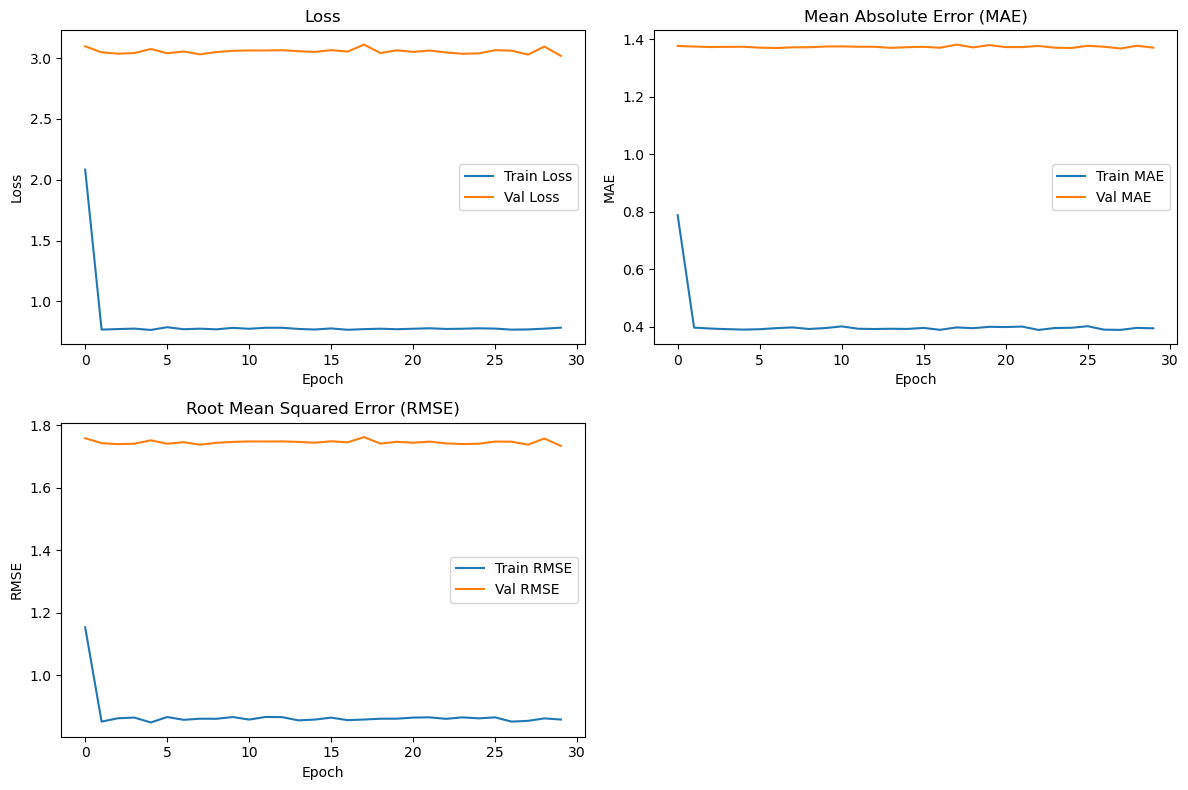

In [10]:
# 그래프 그리기
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Val RMSE')
plt.title('Root Mean Squared Error (RMSE)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# 테스트 데이터셋 로더 생성
test_dataset = StockDataset(test_data, context_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# 테스트 데이터셋 평가
model.eval()
test_loss = 0
with torch.no_grad():
    for returns_to_go, states, actions in test_loader:
        returns_to_go = returns_to_go.to(device)
        states = states.to(device)
        actions = actions.to(device)
        action_preds = model(returns_to_go, states, actions)
        action_preds = action_preds.view(-1)
        actions = actions.unsqueeze(-1)
        test_loss += loss_fn(action_preds, actions).item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 2.6632


/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
